In [1]:
api_link = 'https://db.ygoprodeck.com/api/v7/cardinfo.php'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import requests
import os
import json
import time
import copy
from PIL import Image
import shutil
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import random

In [24]:
if not os.path.exists('data'):
    os.mkdir('data')

In [3]:
jsonPath = os.path.join('data', 'data.json')
jsonDrivePath = os.path.join('gdrive', 'MyDrive', 'jugio', 'data.json')

jsonTruncPath = os.path.join('data', 'data_trunc.json')
jsonTruncDrivePath = os.path.join('gdrive', 'MyDrive', 'jugio', 'data_trunc.json')

cardImgFolderPath = os.path.join('data', 'img')
cardImgArchiveDrivePath = os.path.join('gdrive', 'MyDrive', 'jugio', 'data.tar.gz')
cardImgArchivePath = os.path.join('data.tar.gz')


cardImgSkewedFolderPath = os.path.join('data', 'img_cropped_skewed')

testDataFolderPath = os.path.join('data', 'test_v4')

In [26]:
def downloadCardsJson():
    apiCardsResponse = requests.get(api_link)
    with open(jsonPath, 'w', encoding = 'utf-8') as f:
        f.write(json.dumps(json.loads(apiCardsResponse.text), indent = 4))

In [27]:
def truncateJson():
    with open(jsonPath, 'r', encoding = 'utf-8') as f:
        cardsJson = json.load(f)['data']
        truncCardsJson = []
        for card in cardsJson:
            if card['type'] == 'Token' or card['type'] == 'Skill Card':
                continue

            cardCopy = copy.deepcopy(card)
            if 'archetype' in cardCopy:
                del cardCopy['archetype']
            if 'card_images' in cardCopy:
                del cardCopy['card_images']
            if 'card_sets' in cardCopy:
                del cardCopy['card_sets']
            if 'card_prices' in cardCopy:
                del cardCopy['card_prices']

            for img in card['card_images']:
                artVariantCopy = copy.deepcopy(cardCopy)
                artVariantCopy['id'] = img['id']
                truncCardsJson.append(artVariantCopy)

        with open(jsonTruncPath, 'w', encoding = 'utf-8') as fw:
            fw.write(json.dumps(truncCardsJson, indent = 4))

In [9]:
if os.path.exists(jsonDrivePath):
  !cp {jsonDrivePath} {jsonPath}
else:
  downloadCardsJson()
  !cp {jsonPath} {jsonDrivePath}

In [10]:
if os.path.exists(jsonTruncDrivePath):
  !cp {jsonTruncDrivePath} {jsonTruncPath}
else:
  truncateJson()
  !cp {jsonTruncPath} {jsonTruncDrivePath}

In [28]:
def downloadCardsImages():
    if not os.path.exists(cardImgFolderPath):
        os.mkdir(cardImgFolderPath)
        
    with open(jsonPath, 'r', encoding = 'utf-8') as f:
        cardsJson = json.load(f)['data']
        for card in cardsJson:
            for img in card['card_images']:
                cardImgPath = os.path.join(cardImgFolderPath, str(img['id']) + '.jpg')
                if not os.path.exists(cardImgPath):
                    apiImgResponse = requests.get(img['image_url'])
                    imgContent = apiImgResponse.content
                    with open(cardImgPath, 'wb') as f:
                        f.write(imgContent)
                    print('Downloaded ', img['id'])
                    time.sleep(0.1)
                else:
                    print('Already exists', img['id'])

In [12]:
if os.path.exists(cardImgArchiveDrivePath):
    !tar -xf {cardImgArchiveDrivePath}
else:
    downloadCardsImages()
    !tar -czvf {cardImgArchivePath} {cardImgFolderPath}
    !mv {cardImgArchivePath} {cardImgArchiveDrivePath}

In [29]:
PADDING = 20

In [30]:
ART_X_START = 49 / 421
ART_X_END = 371 / 421
ART_Y_START = 111 / 614
ART_Y_END = 433 / 614

PEND_X_START = 27 / 421
PEND_Y_START = 110 / 614
PEND_X_END = 393 / 421
PEND_Y_END = 381 / 614

In [31]:
skewAugment = A.Compose([
    A.Affine(rotate=[-5,5], shear=[-5,5], p=1),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [32]:
def skewImage(imageObj, bbox):
    skewedImageData = skewAugment(image=np.array(imageObj), bboxes=[bbox], class_labels=['card'])
    dstImage = Image.fromarray(skewedImageData['image'])

    return dstImage, skewedImageData['bboxes'][0]

In [4]:
augment = A.Compose([
    A.RandomBrightnessContrast(p=0.5, brightness_limit=[-0.2,0.3], contrast_limit=[-0.4,0.4]),
    A.HueSaturationValue(hue_shift_limit=[-10,10], sat_shift_limit=[-20, 20], val_shift_limit=[-15,15], p=0.5),
    A.GaussianBlur(p=0.3),
    A.MedianBlur(blur_limit=3, p=0.3),
])

In [5]:
def augmentImage(imageObj):
    augmentImageData = augment(image=np.array(imageObj))
    return Image.fromarray(augmentImageData['image'])

In [22]:
import matplotlib.pyplot as plt

def visualizeRandom(index):
    plt.figure(figsize=(6, 6))
    
    cards = os.listdir(cardImgFolderPath)
    card = os.path.join(cardImgFolderPath, cards[index])
    
    imageObj = Image.open(card)
    
    for i in range(4):
        if i > 0:
            imageObjAug = augmentImage(imageObj)
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(imageObjAug)
            plt.axis("off")
        else:
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(imageObj)
            plt.axis("off")

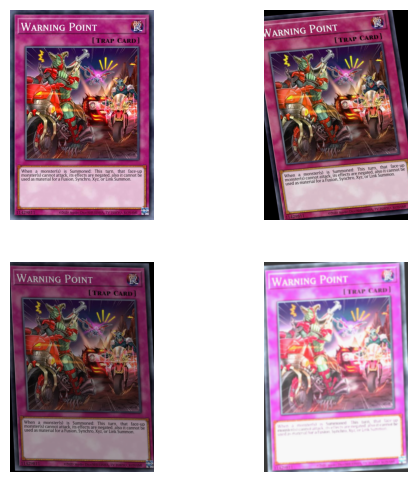

In [38]:
visualizeRandom(256)

In [35]:
def cropImages():
    with open('data/data.json', 'r', encoding = 'utf-8') as f:
        cardsJson = json.load(f)['data']

        cardImgFolderPath = os.path.join('data', 'img')
        cardImgCroppedFolderPath = os.path.join('data', 'img_cropped')
        if not os.path.exists(cardImgCroppedFolderPath):
                    os.mkdir(cardImgCroppedFolderPath)

        for card in cardsJson:
            if card['type'] == 'Token' or card['type'] == 'Skill Card':
                    continue

            for img in card['card_images']:
                cardImgPath = os.path.join(cardImgFolderPath, str(img['id']) + '.jpg')

                cardImgClassFolder = os.path.join(cardImgCroppedFolderPath, str(img['id']))
                if not os.path.exists(cardImgClassFolder):
                    os.mkdir(cardImgClassFolder)

                imgObj = Image.open(cardImgPath)
                cardImgCroppedPath = os.path.join(cardImgClassFolder, str(img['id']) + '.jpg')
                if not os.path.exists(cardImgCroppedPath):
                    width, height = imgObj.size
                    cropped = None
                    if 'Pendulum' in card['type']:
                        cropped = imgObj.crop((width * PEND_X_START, height * PEND_Y_START, width  * PEND_X_END, height * PEND_Y_END))
                    else:    
                        cropped = imgObj.crop((width * ART_X_START, height * ART_Y_START, width  * ART_X_END, height * ART_Y_END))
                    cropped.save(cardImgCroppedPath, 'JPEG')
                    print('Cropped ', img['id'])
                else:
                    print('Already exists', img['id'])

In [36]:
def cropAndRotateImages():
    with open('data/data.json', 'r', encoding = 'utf-8') as f:
        cardsJson = json.load(f)['data']

        cardImgFolderPath = os.path.join('data', 'img')
        cardImgCroppedFolderPath = os.path.join('data', 'img_cropped_rotated')
        if not os.path.exists(cardImgCroppedFolderPath):
                    os.mkdir(cardImgCroppedFolderPath)

        for card in cardsJson:
            if card['type'] == 'Token' or card['type'] == 'Skill Card':
                    continue

            for img in card['card_images']:
                cardImgPath = os.path.join(cardImgFolderPath, str(img['id']) + '.jpg')

                cardImgRotatedFolder = os.path.join(cardImgCroppedFolderPath, str(img['id']))
                if not os.path.exists(cardImgRotatedFolder):
                    os.mkdir(cardImgRotatedFolder)

                imgObj = Image.open(cardImgPath)
                for i in range(12):
                    rotatedImgObj = imgObj.rotate(i*30)
                    cardImgCroppedPath = os.path.join(cardImgRotatedFolder, str(img['id']) + '_' + str(i) + '.jpg')
                    if not os.path.exists(cardImgCroppedPath):
                        width, height = imgObj.size
                        cropped = None
                        if 'Pendulum' in card['type']:
                            cropped = rotatedImgObj.crop((width * PEND_X_START, height * PEND_Y_START, width  * PEND_X_END, height * PEND_Y_END))
                        else:    
                            cropped = rotatedImgObj.crop((width * ART_X_START, height * ART_Y_START, width  * ART_X_END, height * ART_Y_END))
                        cropped.save(cardImgCroppedPath, 'JPEG')
                        print('Cropped and rotated ', img['id'], ' ', str(i))
                    else:
                        print('Already exists', img['id'], ' ', str(i))

In [37]:
def cropAndSkewImages(numberOfSkews=1, shouldAugment=False):
    if not os.path.exists(cardImgSkewedFolderPath):
        os.mkdir(cardImgSkewedFolderPath)
    
    with open(jsonPath, 'r', encoding = 'utf-8') as f:
        cardsJson = json.load(f)['data']

        for card in cardsJson:
            if card['type'] == 'Token' or card['type'] == 'Skill Card':
                    continue

            for img in card['card_images']:
                cardImgPath = os.path.join(cardImgFolderPath, str(img['id']) + '.jpg')

                cardImgSkewedFolder = os.path.join(cardImgSkewedFolderPath, str(img['id']))
                if not os.path.exists(cardImgSkewedFolder):
                    os.mkdir(cardImgSkewedFolder)

                imgObj = Image.open(cardImgPath)
                width, height = imgObj.size
                
                artworkBbox = []
                if 'Pendulum' in card['type']:
                    artworkBbox = [width * PEND_X_START, height * PEND_Y_START, width  * PEND_X_END, height * PEND_Y_END]
                else:    
                    artworkBbox = [width * ART_X_START, height * ART_Y_START, width  * ART_X_END, height * ART_Y_END]
                
                for i in range(numberOfSkews + 1):
                    cardImgSkewedPath = os.path.join(cardImgSkewedFolder, str(img['id']) + '_' + str(i) + '.jpg')
                    if not os.path.exists(cardImgSkewedPath):
                        skewedImgObj, skewedArtworkBbox = None, None
                        if i > 0:
                            skewedImgObj, skewedArtworkBbox = skewImage(imgObj, artworkBbox)
                            if shouldAugment:
                                skewedImgObj = augmentImage(skewedImgObj)
                        else:
                            skewedImgObj, skewedArtworkBbox = imgObj, artworkBbox
                        skewedImgObj = skewedImgObj.crop((skewedArtworkBbox[0], skewedArtworkBbox[1], skewedArtworkBbox[2], skewedArtworkBbox[3]))
                        skewedImgObj.save(cardImgSkewedPath, 'JPEG')
                        print('Cropped and skewed ', img['id'], ' ', str(i))
                    else:
                        print('Already exists', img['id'], ' ', str(i))

In [61]:
!rm -r data/img_cropped_skewed/

In [62]:
cropAndSkewImages(5, True)

Streaming output truncated to the last 5000 lines.
Cropped and skewed  29537493   4
Cropped and skewed  29537493   5
Cropped and skewed  55936191   0
Cropped and skewed  55936191   1
Cropped and skewed  55936191   2
Cropped and skewed  55936191   3
Cropped and skewed  55936191   4
Cropped and skewed  55936191   5
Cropped and skewed  27693363   0
Cropped and skewed  27693363   1
Cropped and skewed  27693363   2
Cropped and skewed  27693363   3
Cropped and skewed  27693363   4
Cropped and skewed  27693363   5
Cropped and skewed  15758127   0
Cropped and skewed  15758127   1
Cropped and skewed  15758127   2
Cropped and skewed  15758127   3
Cropped and skewed  15758127   4
Cropped and skewed  15758127   5
Cropped and skewed  32692693   0
Cropped and skewed  32692693   1
Cropped and skewed  32692693   2
Cropped and skewed  32692693   3
Cropped and skewed  32692693   4
Cropped and skewed  32692693   5
Cropped and skewed  53087962   0
Cropped and skewed  53087962   1
Cropped and skewed  53087

In [63]:
!du -sh {cardImgSkewedFolderPath}

2.3G	data/img_cropped_skewed


In [64]:
!tar -czvf images_skewed.tar.gz data/img_cropped_skewed
!mv images_skewed.tar.gz gdrive/MyDrive/jugio/images_skewed.tar.gz

Streaming output truncated to the last 5000 lines.
data/img_cropped_skewed/1828513/1828513_1.jpg
data/img_cropped_skewed/1828513/1828513_4.jpg
data/img_cropped_skewed/36278828/
data/img_cropped_skewed/36278828/36278828_0.jpg
data/img_cropped_skewed/36278828/36278828_1.jpg
data/img_cropped_skewed/36278828/36278828_2.jpg
data/img_cropped_skewed/36278828/36278828_5.jpg
data/img_cropped_skewed/36278828/36278828_3.jpg
data/img_cropped_skewed/36278828/36278828_4.jpg
data/img_cropped_skewed/67494157/
data/img_cropped_skewed/67494157/67494157_2.jpg
data/img_cropped_skewed/67494157/67494157_0.jpg
data/img_cropped_skewed/67494157/67494157_3.jpg
data/img_cropped_skewed/67494157/67494157_4.jpg
data/img_cropped_skewed/67494157/67494157_1.jpg
data/img_cropped_skewed/67494157/67494157_5.jpg
data/img_cropped_skewed/49460512/
data/img_cropped_skewed/49460512/49460512_5.jpg
data/img_cropped_skewed/49460512/49460512_1.jpg
data/img_cropped_skewed/49460512/49460512_2.jpg
data/img_cropped_skewed/49460512/49

In [38]:
testAugment = A.Compose([
    A.RandomCrop(height=170, width = 170),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=[-0.2,0.3], contrast_limit=[-0.4,0.4]),
    A.HueSaturationValue(hue_shift_limit=[-10,10], sat_shift_limit=[-20, 20], val_shift_limit=[-15,15], p=0.5),
    A.GaussianBlur(p=0.3),
    A.MedianBlur(blur_limit=3, p=0.3),
])

In [39]:
def generateTestData(size=1000):
    if not os.path.exists(testDataFolderPath):
        os.mkdir(testDataFolderPath)
    
    with open(jsonTruncPath, 'r', encoding = 'utf-8') as f:
        cardsJson = json.load(f)
        random.shuffle(cardsJson)
       
        for i in range(size):
            card = cardsJson[i]
            cardSrcPath = os.path.join(cardImgFolderPath, str(card['id']) + '.jpg')
            cardDstPath = os.path.join(testDataFolderPath, str(card['id']) + '.jpg')
            
            imgObj = Image.open(cardSrcPath)
            width, height = imgObj.size
            newImage = Image.new('RGB', (width + PADDING*2,height + PADDING*2))
            newImage.paste(imgObj, (PADDING,PADDING,PADDING+width,PADDING+height))
            imgObj = newImage
                
            artworkBbox = []
            if 'Pendulum' in card['type']:
                artworkBbox = [width * PEND_X_START, height * PEND_Y_START, width  * PEND_X_END, height * PEND_Y_END]
            else:    
                artworkBbox = [width * ART_X_START, height * ART_Y_START, width  * ART_X_END, height * ART_Y_END]
            
            artworkBbox = [x + PADDING for x in artworkBbox]
            
            imgObj, artworkBbox = skewImage(imgObj, artworkBbox)
                        
            imgObj = imgObj.crop((artworkBbox[0], artworkBbox[1], artworkBbox[2], artworkBbox[3]))
            imgObj = imgObj.resize((200, 200))
            imgObj = Image.fromarray(testAugment(image=np.array(imgObj))['image'])
            
            imgObj.save(cardDstPath, format='JPEG')
            print('Created test ', i)

In [40]:
generateTestData()

Created test  0
Created test  1
Created test  2
Created test  3
Created test  4
Created test  5
Created test  6
Created test  7
Created test  8
Created test  9
Created test  10
Created test  11
Created test  12
Created test  13
Created test  14
Created test  15
Created test  16
Created test  17
Created test  18
Created test  19
Created test  20
Created test  21
Created test  22
Created test  23
Created test  24
Created test  25
Created test  26
Created test  27
Created test  28
Created test  29
Created test  30
Created test  31
Created test  32
Created test  33
Created test  34
Created test  35
Created test  36
Created test  37
Created test  38
Created test  39
Created test  40
Created test  41
Created test  42
Created test  43
Created test  44
Created test  45
Created test  46
Created test  47
Created test  48
Created test  49
Created test  50
Created test  51
Created test  52
Created test  53
Created test  54
Created test  55
Created test  56
Created test  57
Created test  58
Created

Created test  462
Created test  463
Created test  464
Created test  465
Created test  466
Created test  467
Created test  468
Created test  469
Created test  470
Created test  471
Created test  472
Created test  473
Created test  474
Created test  475
Created test  476
Created test  477
Created test  478
Created test  479
Created test  480
Created test  481
Created test  482
Created test  483
Created test  484
Created test  485
Created test  486
Created test  487
Created test  488
Created test  489
Created test  490
Created test  491
Created test  492
Created test  493
Created test  494
Created test  495
Created test  496
Created test  497
Created test  498
Created test  499
Created test  500
Created test  501
Created test  502
Created test  503
Created test  504
Created test  505
Created test  506
Created test  507
Created test  508
Created test  509
Created test  510
Created test  511
Created test  512
Created test  513
Created test  514
Created test  515
Created test  516
Created te

Created test  919
Created test  920
Created test  921
Created test  922
Created test  923
Created test  924
Created test  925
Created test  926
Created test  927
Created test  928
Created test  929
Created test  930
Created test  931
Created test  932
Created test  933
Created test  934
Created test  935
Created test  936
Created test  937
Created test  938
Created test  939
Created test  940
Created test  941
Created test  942
Created test  943
Created test  944
Created test  945
Created test  946
Created test  947
Created test  948
Created test  949
Created test  950
Created test  951
Created test  952
Created test  953
Created test  954
Created test  955
Created test  956
Created test  957
Created test  958
Created test  959
Created test  960
Created test  961
Created test  962
Created test  963
Created test  964
Created test  965
Created test  966
Created test  967
Created test  968
Created test  969
Created test  970
Created test  971
Created test  972
Created test  973
Created te

In [ ]:
import albumentations as A
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [ ]:
augment = A.Compose([
    A.Rotate(limit=45),
    A.RandomBrightnessContrast(p=0.75, brightness_limit=[-0.25,0.6], contrast_limit=[-0.6,0.6]),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=50, val_shift_limit=30, p=0.75),
    A.ImageCompression(quality_lower=50, quality_upper=100, p=0.75),
    A.GaussNoise(p=0.75),
    A.GaussianBlur(p=0.75),
    A.Downscale(scale_min=0.25, scale_max=0.75, p=0.75),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25)
])

In [ ]:
imagesPath = os.path.join('data', 'img_cropped_rotated')

In [ ]:
allClasses = os.listdir(imagesPath)
for cardClass in allClasses:
    cardClassFolder = os.path.join(imagesPath, cardClass)
    allCardImgs = os.listdir(cardClassFolder)
    for cardImg in allCardImgs:
        cardImgName, cardImgExt = os.path.splitext(cardImg)
        transImg = cardImgName + '_aug' + cardImgExt
        
        cardImgPath = os.path.join(cardClassFolder, cardImg)
        cardImgObj = Image.open(cardImgPath)
        cardImgArr = np.array(cardImgObj)
        
        transImgArr = augment(image=cardImgArr)['image']
        transImgObj = Image.fromarray(transImgArr)
        transImgObj.save(os.path.join(cardClassFolder, transImg), format='JPEG')
        print('Augmented ', cardImgName)

In [ ]:
!du -sh data/img_cropped_rotated/

In [ ]:
!tar -czvf images.tar.gz data/img_cropped_rotated

In [ ]:
!mv images.tar.gz gdrive/MyDrive/jugio/images.tar.gz

In [ ]:
classificationRootPath = os.path.join('data')
if not os.path.exists(classificationRootPath):
    os.mkdir(classificationRootPath)

In [ ]:
imagesPath = os.path.join(classificationRootPath, 'img_cropped_rotated')
if not os.path.exists(imagesPath):
    os.mkdir(imagesPath)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    imagesPath,
    validation_split=0.1,
    subset='training',
    seed=1234,
    batch_size=batch_size
)

Found 290928 files belonging to 12122 classes.
Using 261836 files for training.


In [ ]:
eval_ds = tf.keras.utils.image_dataset_from_directory(
    imagesPath,
    validation_split=0.1,
    subset='validation',
    seed=1234,
    batch_size=batch_size
)

Found 290928 files belonging to 12122 classes.
Using 29092 files for validation.


In [ ]:
class_names = train_ds.class_names

237.41187
255.0
246.3164
255.0
255.0
255.0
254.75008
255.0
254.25774


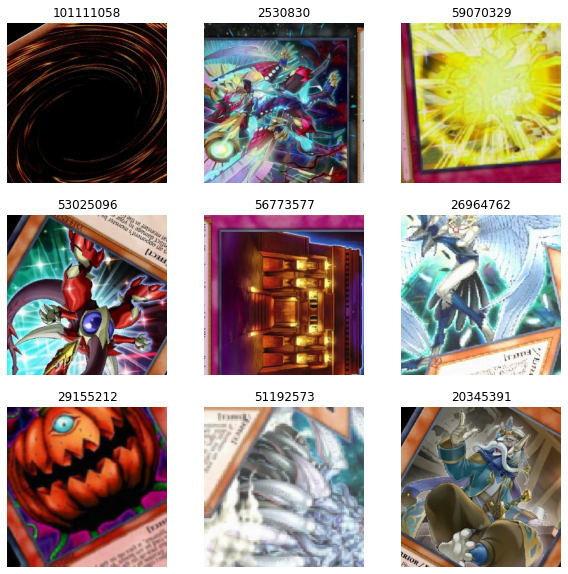

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_ds = train_ds.shuffle(100)
eval_ds = eval_ds

In [ ]:
img_width = 224
img_height = 224

model = Sequential([
    layers.Resizing(img_height, img_width, input_shape=(None, None, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Flatten(),
    layers.Dense(units=4096,activation="relu"),
    layers.Dense(units=4096,activation="relu"),
    layers.Dense(units=len(class_names),activation="softmax")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                      

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=eval_ds,
  epochs=epochs
)

Epoch 1/10
1749/8183 [=====>........................] - ETA: 46:36 - loss: 9.4339 - accuracy: 5.3602e-05

KeyboardInterrupt: ignored